1. Load & prepare Data
2. Calc covariance matrix
3. Calc eigen values & eigen vector
4. Formulate the Q matrix
5. Evaluate Q Matrices
6. Select the best Q
7. Visualization

In [1]:
import kagglehub
yasserh_titanic_dataset_path = kagglehub.dataset_download('yasserh/titanic-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
print(yasserh_titanic_dataset_path)

/root/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1


# Load, Resize & Normalize Data

In [3]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [4]:
dataset_path = '/root/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1/Titanic-Dataset.csv'
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(columns=["Survived", "PassengerId"])
dataset.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dataset.isnull().sum()

,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687
Embarked,2


In [6]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})
features_to_scale = ['Age', 'SibSp', 'Parch', 'Fare']

numeric_columns = dataset.select_dtypes(include=[np.number])
numeric_columns.fillna(numeric_columns.mean(), inplace=True)

X_scaled = numeric_columns.copy()
scaler = StandardScaler()
X_scaled[features_to_scale] = scaler.fit_transform(X_scaled[features_to_scale])

print(X_scaled.head())


   Pclass  Sex       Age     SibSp     Parch      Fare
0       3    0 -0.592481  0.432793 -0.473674 -0.502445
1       1    1  0.638789  0.432793 -0.473674  0.786845
2       3    1 -0.284663 -0.474545 -0.473674 -0.488854
3       1    1  0.407926  0.432793 -0.473674  0.420730
4       3    0  0.407926 -0.474545 -0.473674 -0.486337


In [7]:
train, test = train_test_split(X_scaled, test_size=0.2, random_state=42)
print(train)
print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(test)}")

     Pclass  Sex       Age     SibSp     Parch      Fare
331       1    0  1.215947 -0.474545 -0.473674 -0.074583
733       2    0 -0.515526 -0.474545 -0.473674 -0.386671
382       3    0  0.177063 -0.474545 -0.473674 -0.488854
704       3    0 -0.284663  0.432793 -0.473674 -0.490280
813       3    1 -1.823750  3.154809  2.008933 -0.018709
..      ...  ...       ...       ...       ...       ...
106       3    1 -0.669435 -0.474545 -0.473674 -0.494391
270       1    0  0.000000 -0.474545 -0.473674 -0.024246
860       3    0  0.869652  1.340132 -0.473674 -0.364355
435       1    1 -1.208115  0.432793  2.008933  1.767741
102       1    0 -0.669435 -0.474545  0.767630  0.907738

[712 rows x 6 columns]
Number of training samples: 712
Number of testing samples: 179


# Calc Mean, Shifted FV & Covariance matrix

In [8]:
def mean_centered(X):   #--> shifted fv
    mean = np.mean(X, axis=0)
    shifted_fv = X - mean
    return shifted_fv, mean

In [9]:
def calc_cov_matrix(mean_centered):
    cov_matrix = np.cov(mean_centered, rowvar=False)
    return cov_matrix

train_fv, train_mean = mean_centered(train)
train_cov_matrix = calc_cov_matrix(train_fv)

test_fv, test_mean = mean_centered(test)
test_cov_matrix = calc_cov_matrix(test_fv)

print(f"Shape of Training Covariance Matrix: {train_cov_matrix.shape}")
print(f"Shape of Testing Covariance Matrix: {test_cov_matrix.shape}")

Shape of Training Covariance Matrix: (6, 6)
Shape of Testing Covariance Matrix: (6, 6)


# Calc Eigenvalues & Eigenvector

In [10]:
def power_iteration(A, num_iterations=100):
    n = A.shape[0]
    V = np.random.rand(n)
    for _ in range(num_iterations):
        AV = A.dot(V)
        eigenvalue = np.linalg.norm(AV)
        V = AV / eigenvalue
    return eigenvalue, V

In [11]:
def calculate_eigenvalues_eigenvectors(covariance_matrix, num_iterations):
    n = covariance_matrix.shape[0]
    matrix_copy = np.copy(covariance_matrix).astype(np.float64)
    eigenvectors = np.eye(n)
    eigenvalues = []

    for i in range(n):
        eigenvalue, eigenvector = power_iteration(matrix_copy, num_iterations)
        eigenvalues.append(eigenvalue)
        eigenvectors[:, i] = eigenvector

        matrix_copy -= eigenvalue * np.outer(eigenvector, eigenvector)

    return np.array(eigenvalues), eigenvectors

num_iterations = 100
eigenvalues, eigenvectors = calculate_eigenvalues_eigenvectors(train_cov_matrix, num_iterations)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
print(eigenvectors)


Eigenvalues: [1.76106199 1.50803841 0.74180392 0.57947443 0.31602969 0.19948931]
Eigenvectors:
[[-0.0323042   0.54913855  0.10436588  0.06697047 -0.8107932   0.15697263]
 [ 0.09563688 -0.04316119 -0.04679264  0.12200227  0.15936673  0.972892  ]
 [-0.3146822  -0.47976384  0.78934543  0.08139499 -0.19077863  0.06865818]
 [ 0.65723133  0.15087067  0.43378401 -0.59072484  0.08743628  0.02270492]
 [ 0.57438366  0.01879067  0.18489817  0.78095164  0.04859779 -0.15262959]
 [ 0.35904809 -0.66580446 -0.37615968 -0.12314204 -0.52039725  0.01776247]]


# Formulate the Q matrix using selected eigenvectors

In [12]:
k_values = [1, 2, 3, 4, 5, 6]

best_Q_matrices = {}
best_variance_explained = {}
explained_variances = []

total_variance = np.sum(eigenvalues)


for k in k_values:
    max_variance = 0
    best_Q = None
    print(f"\nFor k = {k}, evaluating Q matrices:")

    for indices in combinations(range(eigenvectors.shape[1]), k):
        Q = eigenvectors[:, indices]
        variance_explained = np.sum(eigenvalues[list(indices)]) / total_variance * 100

        print(f"Indices: {indices}, Variance Explained: {variance_explained:.2f}%")

        if variance_explained > max_variance:
            max_variance = variance_explained
            best_Q = Q

    print(f"Shape of Q: {best_Q.shape}")
    best_Q_matrices[k] = best_Q
    best_variance_explained[k] = max_variance
    explained_variances.append(max_variance)


For k = 1, evaluating Q matrices:
Indices: (0,), Variance Explained: 34.49%
Indices: (1,), Variance Explained: 29.54%
Indices: (2,), Variance Explained: 14.53%
Indices: (3,), Variance Explained: 11.35%
Indices: (4,), Variance Explained: 6.19%
Indices: (5,), Variance Explained: 3.91%
Shape of Q: (6, 1)

For k = 2, evaluating Q matrices:
Indices: (0, 1), Variance Explained: 64.03%
Indices: (0, 2), Variance Explained: 49.02%
Indices: (0, 3), Variance Explained: 45.84%
Indices: (0, 4), Variance Explained: 40.68%
Indices: (0, 5), Variance Explained: 38.40%
Indices: (1, 2), Variance Explained: 44.06%
Indices: (1, 3), Variance Explained: 40.88%
Indices: (1, 4), Variance Explained: 35.72%
Indices: (1, 5), Variance Explained: 33.44%
Indices: (2, 3), Variance Explained: 25.88%
Indices: (2, 4), Variance Explained: 20.72%
Indices: (2, 5), Variance Explained: 18.44%
Indices: (3, 4), Variance Explained: 17.54%
Indices: (3, 5), Variance Explained: 15.26%
Indices: (4, 5), Variance Explained: 10.10%
S

# Transformation

In [13]:
chosen_k = 5
final_Q = best_Q_matrices[chosen_k]
transformed_data = train_fv.dot(final_Q)

print(f"Shape of Transformed Data (k={chosen_k}): {transformed_data.shape}")

Shape of Transformed Data (k=5): (712, 5)


# Evaluate Q Matrices

In [14]:
train_cov_matrix = np.cov(train_fv.T)

In [15]:
def calculate_reconstruction_error(original_data, transformed_data, Q):

    reconstructed_data = transformed_data @ Q.T
    original_data = np.array(original_data)
    mse = np.mean((original_data - reconstructed_data) ** 2)

    print(f"Original Data Shape: {original_data.shape}")
    print(f"Reconstructed Data Shape: {reconstructed_data.shape}")

    return mse

In [16]:
print(f"Q^T * Q:\n{final_Q.T @ final_Q}")

Q^T * Q:
[[ 1.00000000e+00  2.30026306e-08  1.64470460e-16 -1.04641973e-16
   1.41181899e-16]
 [ 2.30026306e-08  1.00000000e+00  5.12471008e-17  4.27354517e-17
  -1.15415626e-17]
 [ 1.64470460e-16  5.12471008e-17  1.00000000e+00  5.45659069e-12
   2.61694953e-17]
 [-1.04641973e-16  4.27354517e-17  5.45659069e-12  1.00000000e+00
  -1.33467214e-17]
 [ 1.41181899e-16 -1.15415626e-17  2.61694953e-17 -1.33467214e-17
   1.00000000e+00]]


In [17]:
reconstruction_error = calculate_reconstruction_error(train_fv, transformed_data, final_Q)
print(f"Reconstruction Error for k={chosen_k}: {reconstruction_error:.6f}")

Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)
Reconstruction Error for k=5: 0.033202


# Visualize explained variance ratio

In [18]:
def plot_explained_variance(k_values, explained_variances):
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, explained_variances, marker='o', label="Variance Explained")
    plt.xlabel("Number of Components (k)")
    plt.ylabel("Variance Explained (%)")
    plt.title("Explained Variance vs. Number of Components")
    plt.grid()
    plt.legend()
    plt.show()

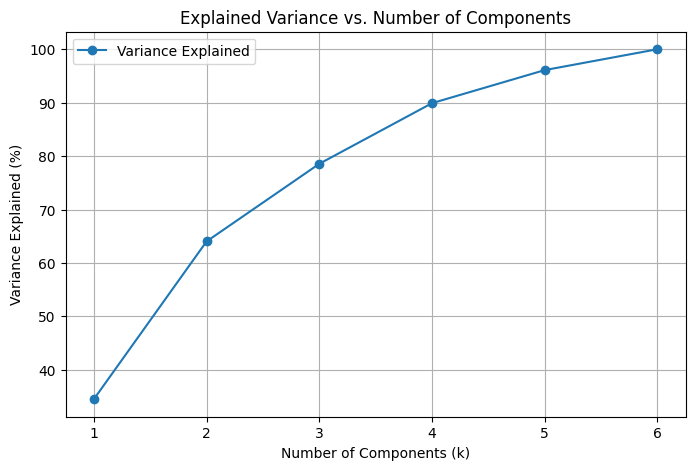

In [19]:
plot_explained_variance(k_values, explained_variances)

In [20]:
k_values = [1, 2, 3, 4, 5]
explained_variances = []
reconstruction_errors = []

total_variance = np.sum(eigenvalues)

for k in k_values:
    max_variance = 0
    best_Q = None

    for indices in combinations(range(eigenvectors.shape[1]), k):
        Q = eigenvectors[:, indices]
        variance_explained = np.sum(eigenvalues[list(indices)]) / total_variance * 100

        if variance_explained > max_variance:
            max_variance = variance_explained
            best_Q = Q

    explained_variances.append(max_variance)


    transformed_data = train_fv.dot(best_Q)
    reconstruction_error = calculate_reconstruction_error(train_fv, transformed_data, best_Q)
    reconstruction_errors.append(reconstruction_error)

Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)
Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)
Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)
Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)
Original Data Shape: (712, 6)
Reconstructed Data Shape: (712, 6)


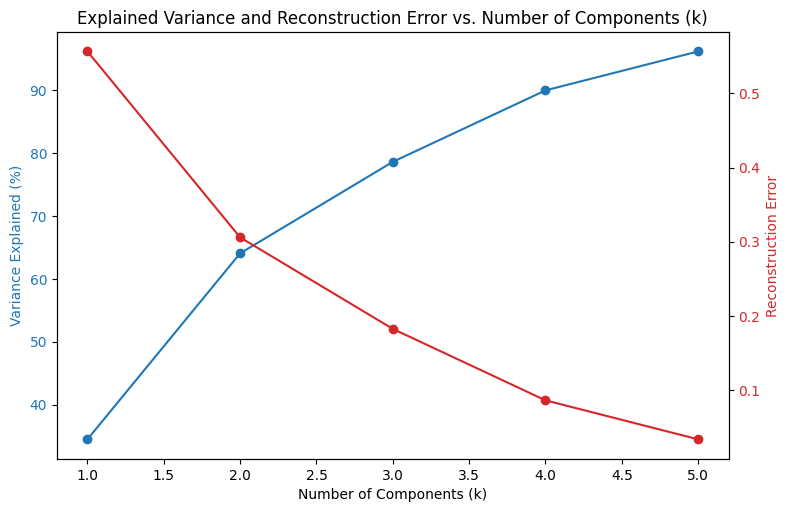


Best k based on reconstruction error: 5
Lowest Reconstruction Error: 0.033202


In [21]:
def plot_results(k_values, explained_variances, reconstruction_errors):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.set_xlabel("Number of Components (k)")
    ax1.set_ylabel("Variance Explained (%)", color="tab:blue")
    ax1.plot(k_values, explained_variances, marker='o', color="tab:blue", label="Variance Explained")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Reconstruction Error", color="tab:red")
    ax2.plot(k_values, reconstruction_errors, marker='o', color="tab:red", label="Reconstruction Error")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    fig.tight_layout()
    plt.title("Explained Variance and Reconstruction Error vs. Number of Components (k)")
    plt.show()


plot_results(k_values, explained_variances, reconstruction_errors)


best_k = k_values[np.argmin(reconstruction_errors)]
print(f"\nBest k based on reconstruction error: {best_k}")
lowest_reconstruction_error = np.min(reconstruction_errors)
print(f"Lowest Reconstruction Error: {lowest_reconstruction_error:.6f}")

In [22]:
for i in range(len(k_values)):
    print(f"For k = {k_values[i]}, Reconstruction Error = {reconstruction_errors[i]:.6f}")


For k = 1, Reconstruction Error = 0.556690
For k = 2, Reconstruction Error = 0.305703
For k = 3, Reconstruction Error = 0.182243
For k = 4, Reconstruction Error = 0.085799
For k = 5, Reconstruction Error = 0.033202
